In [1]:
from google.colab import drive  # dihapus aja kalo ga pake colab
from google.colab.patches import cv2_imshow  # dihapus aja kalo ga pake colab

drive.mount('/content/drive') # dihapus aja kalo ga pake colab
absPath = "/content/drive/My Drive/Current Project/unet/" # diganti sesuai pathnya

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras


def unet(pretrained_weights = None,input_size = (256,256,1)):
    inputs = Input(input_size)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(inputs)
    conv1 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool1)
    conv2 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool2)
    conv3 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool3)
    conv4 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv4)
    drop4 = Dropout(0.5)(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(drop4)

    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(pool4)
    conv5 = Conv2D(1024, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv5)
    drop5 = Dropout(0.5)(conv5)

    up6 = Conv2D(512, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(drop5))
    merge6 = concatenate([drop4,up6], axis = 3)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge6)
    conv6 = Conv2D(512, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv6)

    up7 = Conv2D(256, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv6))
    merge7 = concatenate([conv3,up7], axis = 3)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge7)
    conv7 = Conv2D(256, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv7)

    up8 = Conv2D(128, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv7))
    merge8 = concatenate([conv2,up8], axis = 3)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge8)
    conv8 = Conv2D(128, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv8)

    up9 = Conv2D(64, 2, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(UpSampling2D(size = (2,2))(conv8))
    merge9 = concatenate([conv1,up9], axis = 3)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(merge9)
    conv9 = Conv2D(64, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv9 = Conv2D(2, 3, activation = 'relu', padding = 'same', kernel_initializer = 'he_normal')(conv9)
    conv10 = Conv2D(1, 1, activation = 'sigmoid')(conv9)

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(lr = 1e-4), loss = 'binary_crossentropy', metrics = ['accuracy']) # ganti optimizer sama learning rate di sini
    
    #model.summary()

    if(pretrained_weights):
    	model.load_weights(pretrained_weights)

    return model



In [3]:
from keras.preprocessing.image import ImageDataGenerator
import numpy as np

def adjustData(img,mask,flag_multi_class,num_class):
    if(flag_multi_class):
        img = img / 255
        mask = mask[:,:,:,0] if(len(mask.shape) == 4) else mask[:,:,0]
        new_mask = np.zeros(mask.shape + (num_class,))
        for i in range(num_class):
            #for one pixel in the image, find the class in mask and convert it into one-hot vector
            #index = np.where(mask == i)
            #index_mask = (index[0],index[1],index[2],np.zeros(len(index[0]),dtype = np.int64) + i) if (len(mask.shape) == 4) else (index[0],index[1],np.zeros(len(index[0]),dtype = np.int64) + i)
            #new_mask[index_mask] = 1
            new_mask[mask == i,i] = 1
        new_mask = np.reshape(new_mask,(new_mask.shape[0],new_mask.shape[1]*new_mask.shape[2],new_mask.shape[3])) if flag_multi_class else np.reshape(new_mask,(new_mask.shape[0]*new_mask.shape[1],new_mask.shape[2]))
        mask = new_mask
    elif(np.max(img) > 1):
        img = img / 255
        mask = mask /255
        mask[mask > 0.5] = 1
        mask[mask <= 0.5] = 0
    return (img,mask)



def trainGenerator(batch_size,train_path,image_folder,mask_folder,aug_dict,image_color_mode = "grayscale",
                    mask_color_mode = "grayscale",image_save_prefix  = "image",mask_save_prefix  = "mask",
                    flag_multi_class = False,num_class = 2,save_to_dir = None,target_size = (256,256),seed = 1):
    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)
    image_generator = image_datagen.flow_from_directory(
        train_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = image_save_prefix,
        seed = seed)
    mask_generator = mask_datagen.flow_from_directory(
        train_path,
        classes = [mask_folder],
        class_mode = None,
        color_mode = mask_color_mode,
        target_size = target_size,
        batch_size = batch_size,
        save_to_dir = save_to_dir,
        save_prefix  = mask_save_prefix,
        seed = seed)
    train_generator = zip(image_generator, mask_generator)
    for (img,mask) in train_generator:
        img,mask = adjustData(img,mask,flag_multi_class,num_class)
        yield (img,mask)

Instructions for updating:
Please use Model.fit, which supports generators.
Found 100 images belonging to 1 classes.
Found 100 images belonging to 1 classes.
Epoch 1/12
25/25 [==============================] - ETA: 0s - loss: 0.6928 - accuracy: 0.8207
Epoch 00001: loss improved from inf to 0.69281, saving model to weights.h5
25/25 [==============================] - 115s 5s/step - loss: 0.6928 - accuracy: 0.8207
Epoch 2/12
25/25 [==============================] - ETA: 0s - loss: 0.6920 - accuracy: 0.8204
Epoch 00002: loss improved from 0.69281 to 0.69197, saving model to weights.h5
25/25 [==============================] - 5s 219ms/step - loss: 0.6920 - accuracy: 0.8204
Epoch 3/12
25/25 [==============================] - ETA: 0s - loss: 0.6912 - accuracy: 0.8194
Epoch 00003: loss improved from 0.69197 to 0.69118, saving model to weights.h5
25/25 [==============================] - 5s 198ms/step - loss: 0.6912 - accuracy: 0.8194
Epoch 4/12
25/25 [==============================] - ETA: 0s -

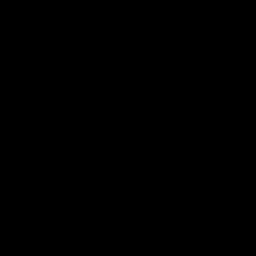

label:


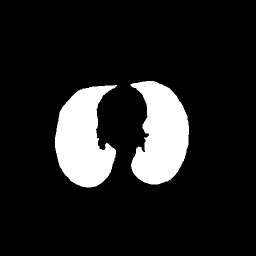

intersection:


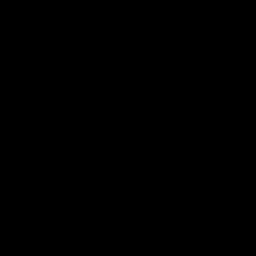

union:


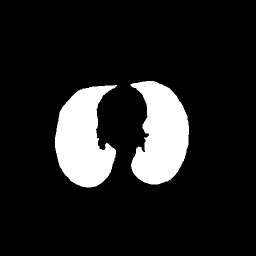

/content/drive/My Drive/Current Project/unet/data/test/image/000021.jpg
0.0
result:


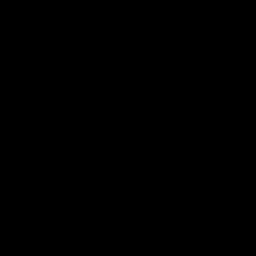

label:


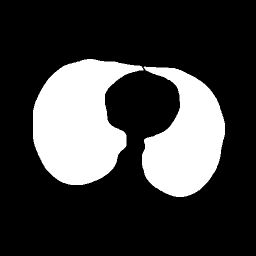

intersection:


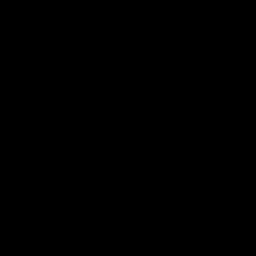

union:


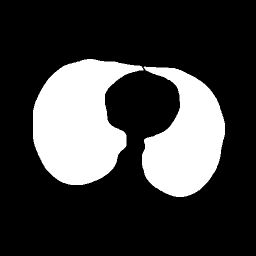

/content/drive/My Drive/Current Project/unet/data/test/image/1.jpg
0.0
result:


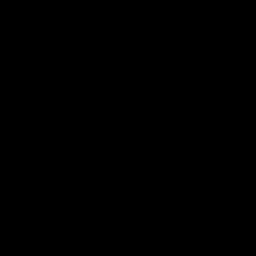

label:


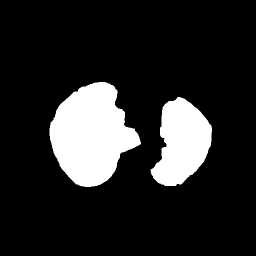

intersection:


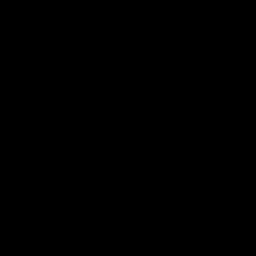

union:


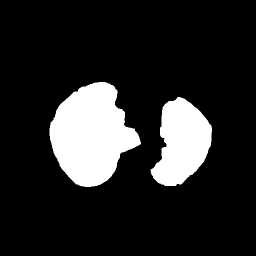

/content/drive/My Drive/Current Project/unet/data/test/image/10.jpg
0.0
result:


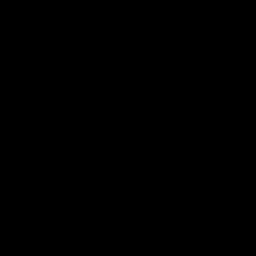

label:


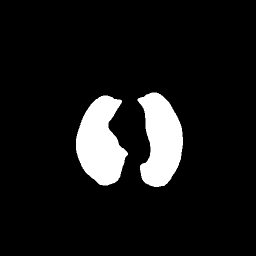

intersection:


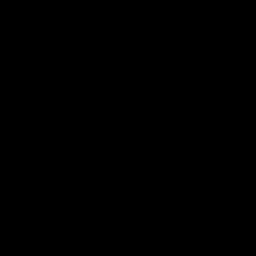

union:


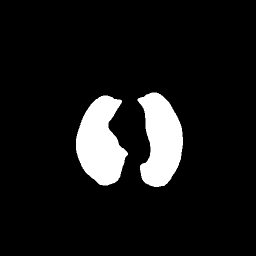

/content/drive/My Drive/Current Project/unet/data/test/image/14.jpg
0.0
result:


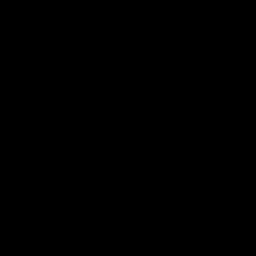

label:


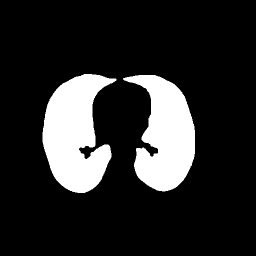

intersection:


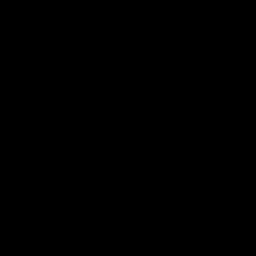

union:


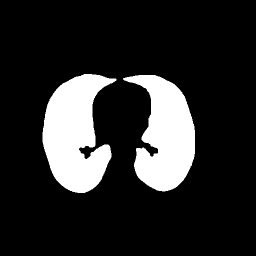

/content/drive/My Drive/Current Project/unet/data/test/image/19.jpg
0.0
result:


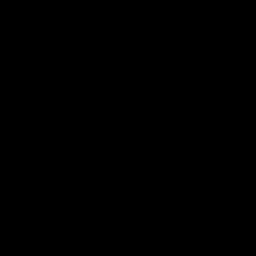

label:


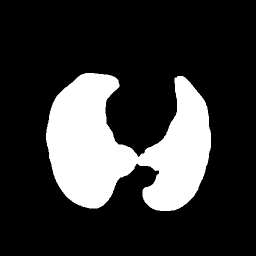

intersection:


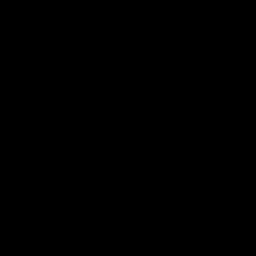

union:


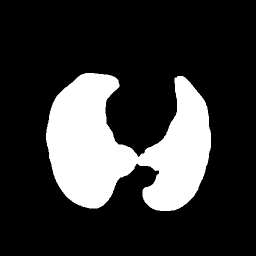

/content/drive/My Drive/Current Project/unet/data/test/image/28.jpg
0.0
result:


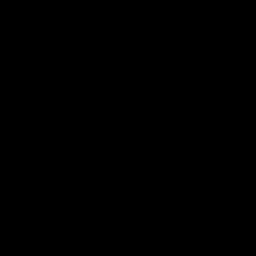

label:


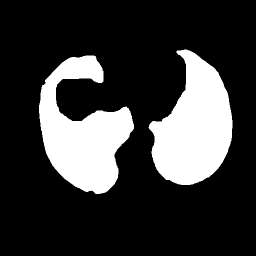

intersection:


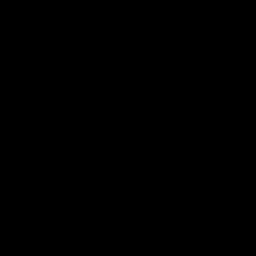

union:


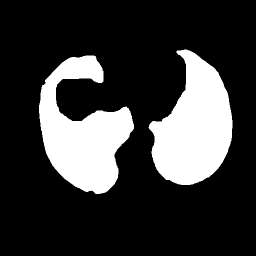

/content/drive/My Drive/Current Project/unet/data/test/image/33.jpg
0.0
result:


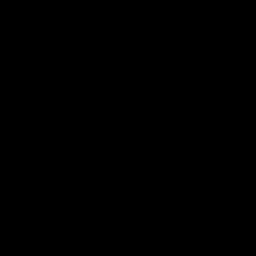

label:


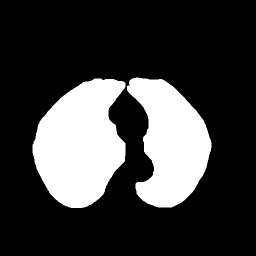

intersection:


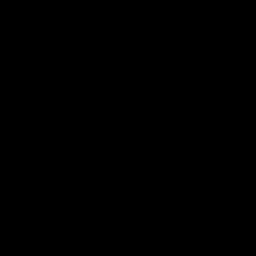

union:


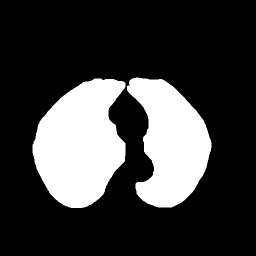

/content/drive/My Drive/Current Project/unet/data/test/image/37.jpg
0.0
result:


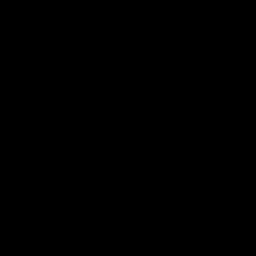

label:


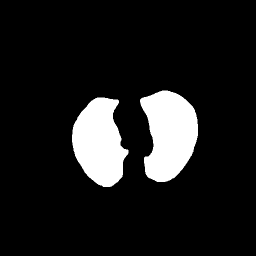

intersection:


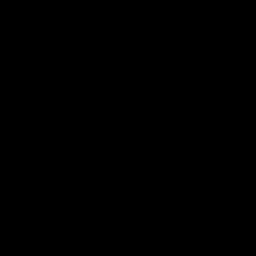

union:


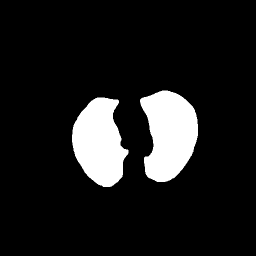

/content/drive/My Drive/Current Project/unet/data/test/image/2f.jpg
0.0
result:


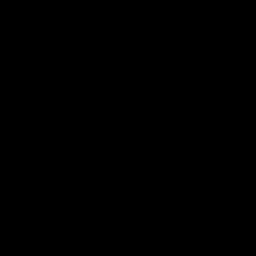

label:


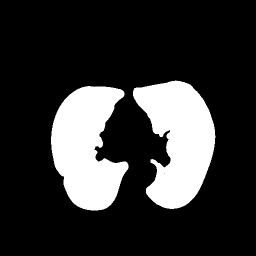

intersection:


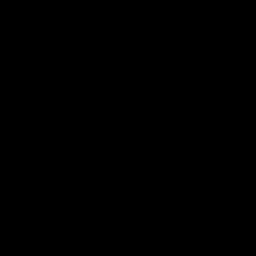

union:


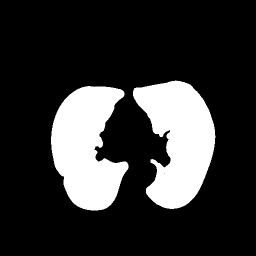

/content/drive/My Drive/Current Project/unet/data/test/image/23f.jpg
0.0
result:


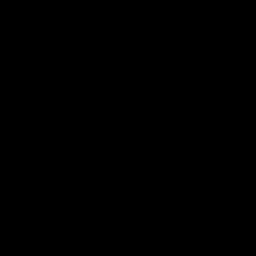

label:


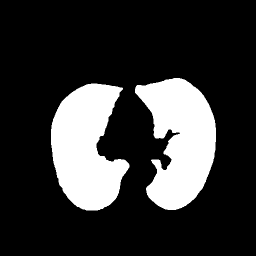

intersection:


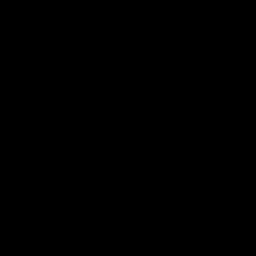

union:


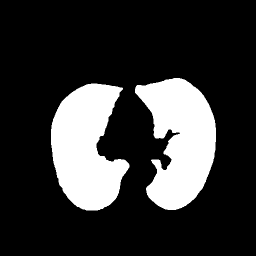

/content/drive/My Drive/Current Project/unet/data/test/image/28f.jpg
0.0
result:


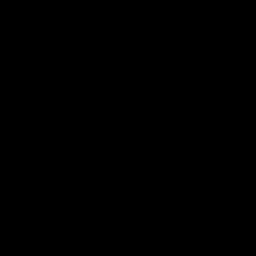

label:


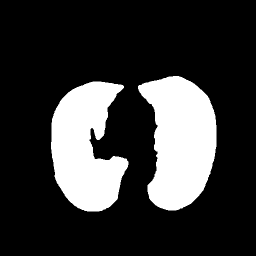

intersection:


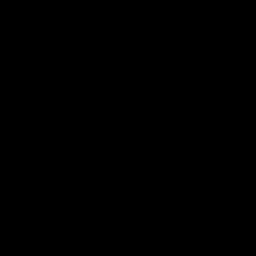

union:


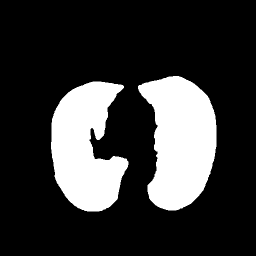

/content/drive/My Drive/Current Project/unet/data/test/image/11f.jpg
0.0
result:


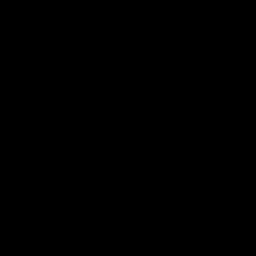

label:


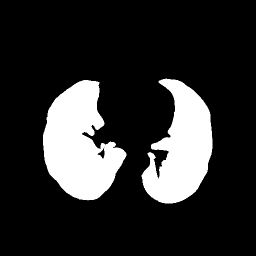

intersection:


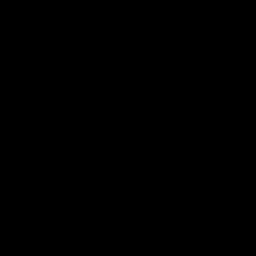

union:


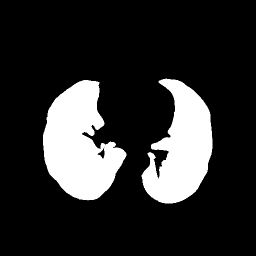

/content/drive/My Drive/Current Project/unet/data/test/image/20f.jpg
0.0
result:


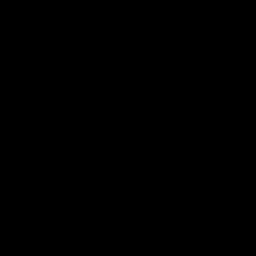

label:


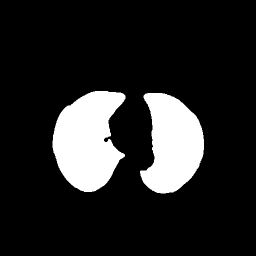

intersection:


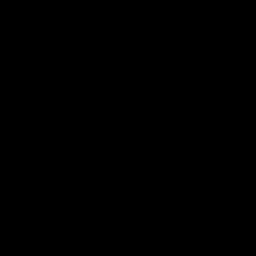

union:


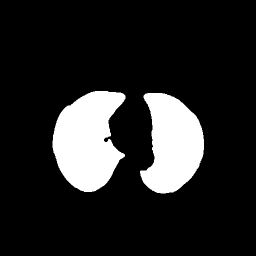

/content/drive/My Drive/Current Project/unet/data/test/image/7f.jpg
0.0
result:


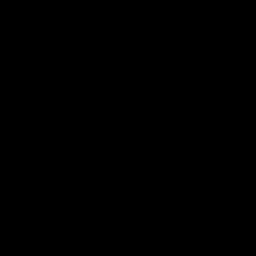

label:


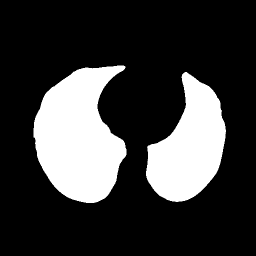

intersection:


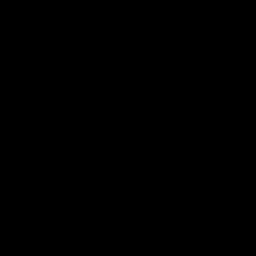

union:


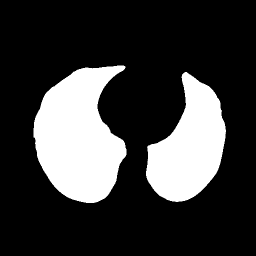

Overall IoU: 0.0


In [4]:
from glob import glob
from math import ceil
import numpy as np
import cv2

# ganti2 di sini ajaa
train = True
show_image = True
fill = True # fill ini untuk ngisi kontur kalo ada lubang di tengah
batch_size = 4 # jumlah batch
epochs = 12 # jumlah epoch
target_size = (256,256,1) # input output image size

if train:
    numData = len(glob(absPath+"data/train/image/*"))
    numLabel = len(glob(absPath+"data/train/label/*"))
    if numData != numLabel:
        print("Error: number of image and label is different")
        exit()
        
    data_gen_args = dict(rotation_range=0.2,
                        width_shift_range=0.05,
                        height_shift_range=0.05,
                        shear_range=0.05,
                        zoom_range=0.05,
                        horizontal_flip=True,
                        fill_mode='nearest') # augmentasi gambar
    myGene = trainGenerator(batch_size,absPath+'data/train','image','label',data_gen_args,target_size=target_size[:2]) # untuk training dengan argumen: batch size, folder path, training image folder path, training label folder path, data generator args

    model = unet(input_size=target_size) # membangun model unet yang sudah didefinisikan
    model_checkpoint = ModelCheckpoint('weights.h5', monitor='loss', verbose=1, save_best_only=True)
    model.fit_generator(myGene,steps_per_epoch=ceil(numData//batch_size),epochs=epochs, callbacks=[model_checkpoint]) # mulai training
    model.save(absPath+"weights.h5")

model = unet(absPath+"weights.h5") # load saved model
iou = 0
cnt = 0
print("Testing")
for img in glob(absPath+"data/test/image/*.jpg"): # read image satu per satu di suatu folder
    print(img)
    image = cv2.imread(img, 0) # read image
    label = cv2.imread(img.replace("image", "label"), 0) # read label
    image = image / 255 # normalisasi image
    image = cv2.resize(image, target_size[:2]) # menyesuaikan input output size
    label = cv2.resize(label, target_size[:2]) # menyesuaikan input output size
    image = np.reshape(image,(1,)+image.shape+(1,)) # menyesuaikan shape untuk dimasukkan ke model
    label = np.reshape(label, label.shape+(1,)) # menyesuaikan shape untuk dimasukkan ke model
    ret, result = cv2.threshold((model.predict(image))[0], 0.5, 1, 0) # memprediksi image
    result = np.reshape((np.array(result, dtype=np.uint8))*255, label.shape) # mengembalikan nilai image ke range 0 sampai 255
    contours, hierarchy = cv2.findContours(result, cv2.RETR_TREE, cv2.CHAIN_APPROX_NONE) # mencari kontur
    if fill:
        for i in range(len(contours)): # loop setiap kontur yang ada
            cv2.drawContours(result, contours, i, 255, cv2.FILLED) # mengisi kontur dengan warna putih
    intersection = np.array(np.bitwise_and(result, label), dtype=np.uint8) # menghitung irisan
    union = np.array(np.bitwise_or(result, label), dtype=np.uint8) # meghitung gabungan
    IoU = np.sum(intersection)/np.sum(union) # menghitung IoU
    iou += IoU
    cnt+=1
    print(IoU)
    if show_image: #menampilkan gambar pakai google colab
        print("result:")
        cv2_imshow(result)
        print("label:")
        cv2_imshow(label)
        print("intersection:")
        cv2_imshow(intersection)
        print("union:")
        cv2_imshow(union)

    # if show_image: #menampilkan gambar pakai opencv
    #     cv2.imshow("result", result)
    #     cv2.imshow("label", label)
    #     cv2.imshow("intersection", intersect)
    #     cv2.imshow("union", union)
  
try: print("Overall IoU:", iou/cnt)
except: print("No image found")